This notebook will test how similar the directionalities of the Knowles SPU-0410 mics are. 

notebook initiation: 2021-06-08

In [1]:
import datetime as dt
import glob
import os
import sys
sys.path.append('../../')
sys.path.append('../')
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec
import numpy as np 
import pandas as pd
import soundfile as sf
import scipy.signal as signal 
import tqdm

import playback_code
import playback_code.playback_analysis as pa
from fullscale_calculations import *

In [2]:
%matplotlib notebook

In [3]:

def get_loudest_part(X, fs=192000, winsize=0.025, threshold=20):
    x_sq = np.sqrt(np.abs(X)**2)
    winsamples = int(fs*winsize)
    running_mean = np.convolve(x_sq, np.ones(winsamples)/winsamples, mode='same')
    #threshold = np.percentile(running_mean, windowlimit)
    db_runningmean = 20*np.log10(running_mean)
    indices =  db_runningmean >= np.max(db_runningmean)-threshold
    return indices, running_mean

def calculate_tones_rec_level(audio, fs, tone_freqs, FS_dbu, gain, sensitivity_dbvrms, freq_bw=500):
    '''
    '''
    
    audio_parts = np.array_split(audio, len(tone_freqs))
    
    tones_rms = []
    for peak_freq, tone_part in zip(tone_freqs, audio_parts):
        loudest_inds, _ = get_loudest_part(tone_part, fs=fs)
        audio_part = tone_part[loudest_inds]
        signal_fft = np.fft.fft(audio_part)
        fftfreqs = np.fft.fftfreq(audio_part.size, 1/fs)
        if np.logical_or(peak_freq<=0, peak_freq>=fs*0.5):
            raise ValueError(f'A peakfrequency <0 or > Nyquist frequency ({peak_freq}Hz) has been detected. Aborting....')
        signal_band = np.array([peak_freq-freq_bw, peak_freq+freq_bw])
        signal_band[signal_band<0] = 0
        signal_band[signal_band>fs*0.5] = fs*0.5
        rms_value = pa.extract_bandrms_from_fft(signal_band, signal_fft, fftfreqs)
        tones_rms.append(rms_value)
    
    #tones_rms = pa.get_tones_rms(audio, tone_freqs,fs=fs,bandwidth=freq_bw)
    tones_rms = pd.DataFrame(data={'tone_rms':tones_rms})
    max_rms = 1/(np.sqrt(2)) # for Vp=1 Vrms = (1/sqrt(2))*Vp
    tones_rms['dbrms_re_max'] = pa.dB(tones_rms['tone_rms']/max_rms)
    tones_rms['dbrms_wogain'] = tones_rms['dbrms_re_max']-gain
    tones_rms['db_FS'] = pa.dB(dbu2vrms(FS_dbu))
    tones_rms['tone_db'] = tones_rms['db_FS'] + tones_rms['dbrms_wogain']
    tones_rms['tone_freqs'] = tone_freqs
    sensitivity_vrms = 10**(sensitivity_dbvrms/20.0) # Vrms/Pa
    ref = 20*10**-6 # Pa

    tones_rms['Pa_rms'] = 10**(tones_rms['tone_db']/20.0)*(1/sensitivity_vrms)
    tones_rms['dbspl_rms'] = pa.dB(tones_rms['Pa_rms']/ref)
    return tones_rms


def make_avged_fft(recording_name, fft_dictionary):
    # first check all ffts are the same size 
    fft_sizes = [len(fft_dictionary[recording_name][i][:,1]) for i in range(5)]
    if not np.all(np.array(fft_sizes)==fft_sizes[0]):
        raise ValueError(f'all FFTs not same size: {fft_sizes}')
    all_ffts = np.array([fft_dictionary[recording_name][i][:,1] for i in range(5)]).reshape(5,-1)
    avg_fft = 20*np.log10(np.mean(10**(all_ffts/20.0), axis=0))
    freqs = fft_dictionary[recording_name][0][:,0]
    return avg_fft, freqs

def calculate_average_sweep_spectrum(audio, fs):
    sweeps = np.array_split(audio[int(fs*0.5):int(fs*1.5)],5)

    sweep_ffts = {}

    for i,each in enumerate(sweeps):
        sweeps_bp = signal.lfilter(b,a,each)
        sweepregion, _ = get_loudest_part(sweeps_bp)
        sweep_only = sweeps_bp[sweepregion]
        sweeps_fft = 20*np.log10(np.abs(np.fft.rfft(sweep_only)))
        sweeps_freq = np.fft.rfftfreq(sweep_only.size,1.0/fs)
        sweep_ffts[i] = np.column_stack((sweeps_freq, sweeps_fft))
    # make 'average' sweep spectrum
    avgd_fft, freqs = make_avged_fft('1', {'1':sweep_ffts})
    return freqs, avgd_fft



def get_avg_sweep_spectrum(fname):
    audio, fs = sf.read(fname)
    freqs, spectrum = calculate_average_sweep_spectrum(audio, fs)
    return freqs, spectrum


fs = 192000
b,a = signal.butter(2, np.array([9000,95500])/(fs*0.5), 'bandpass')

In [4]:
audio_recs = glob.glob('../../2021-06-07/*.wav')
smp4_recs = list(filter(lambda X: 'smp4' in X, audio_recs))
smp7_recs = list(filter(lambda X: 'smp7' in X, audio_recs))

In [5]:
onaxissmp4_recs = list(filter(lambda X: '_angle_0_' in X, smp4_recs))
onaxis_smp4_audio = [signal.lfilter(b,a,pa.get_only_tones(sf.read(each)[0],1.5)) for each in onaxissmp4_recs]

onaxissmp7_recs = list(filter(lambda X: '_angle_0_' in X, smp7_recs))
onaxis_smp7_audio = [signal.lfilter(b,a,pa.get_only_tones(sf.read(each)[0],1.5)) for each in onaxissmp7_recs]

onaxissmp4_recs

['../../2021-06-07\\smp4-2mwall_amp401_speaker504_gaindB_30_azimuth_angle_0_2021-06-07_17-24-10.wav',
 '../../2021-06-07\\smp4-2mwall_amp401_speaker504_gaindB_30_azimuth_angle_0_2021-06-07_17-30-09.wav']

In [6]:
onaxissmp7_recs

['../../2021-06-07\\smp7-2mwall_amp401_speaker504_gaindB_30_azimuth_angle_0_2021-06-07_17-02-00.wav',
 '../../2021-06-07\\smp7-2mwall_amp401_speaker504_gaindB_30_azimuth_angle_0_2021-06-07_17-03-12.wav',
 '../../2021-06-07\\smp7-2mwall_amp401_speaker504_gaindB_30_azimuth_angle_0_2021-06-07_17-04-50.wav',
 '../../2021-06-07\\smp7-2mwall_amp401_speaker504_gaindB_30_azimuth_angle_0_2021-06-07_17-11-31.wav']

In [7]:
fs = 192000
fireface_dbu_FS = 27
spu_dbVrmsPa = -42 # just take a typical value --THIS IS NOT AN EXACT VALUE!!!!
rec_gain = 30
tonefreqs = np.arange(10000, 95000, 1000)



In [8]:
# quality checks - make sure the 1st and last on-axis levels are similar. 
smp4_onaxis_data = []
for each in onaxis_smp4_audio:
    out = calculate_tones_rec_level(each, fs, tonefreqs, fireface_dbu_FS, rec_gain, spu_dbVrmsPa, freq_bw=500)
    smp4_onaxis_data.append(out)
    
smp7_onaxis_data = []
for each in onaxis_smp7_audio:
    out = calculate_tones_rec_level(each, fs, tonefreqs, fireface_dbu_FS, rec_gain, spu_dbVrmsPa, freq_bw=500)
    smp7_onaxis_data.append(out)



<IPython.core.display.Javascript object>


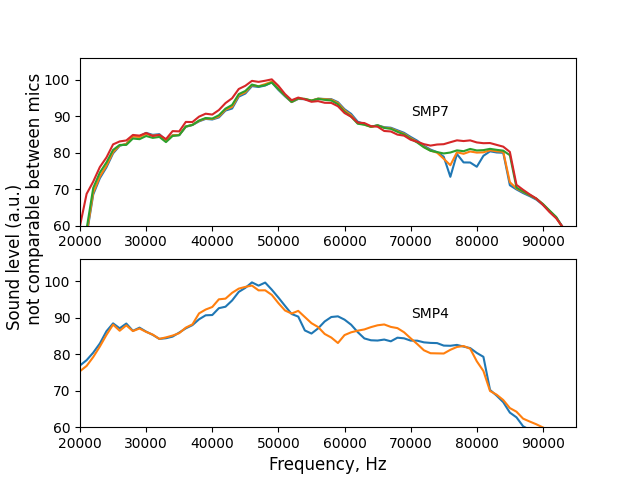

Text(0.5, 0, 'Frequency, Hz')

In [9]:
plt.figure()
a00 = plt.subplot(211)
plt.text(70000,90,'SMP7')
for each in smp7_onaxis_data:
    plt.plot(tonefreqs, each['dbspl_rms'])
plt.xlim(20000,95000);
plt.ylim(60,106)

a01 = plt.subplot(212, sharex=a00, sharey=a00)
plt.text(70000,90,'SMP4')
plt.plot(tonefreqs, smp4_onaxis_data[0]['dbspl_rms'])
plt.plot(tonefreqs, smp4_onaxis_data[1]['dbspl_rms'])
plt.text(-0.15, 0.6,'Sound level (a.u.)   \n not comparable between mics', 
         rotation=90, transform=plt.gca().transAxes, fontsize=12)
plt.xlabel('Frequency, Hz', fontsize=12)

### This result deserves more inspection and troubleshooting -- *where is the recording variation coming from*?

1. Microphone variation 
1. Positional variation (rotation/orientation of the mic platform)
1. Speaker playback variation

This needs to be figured out soon. 

In [10]:
print(f'This cell executed at: {dt.datetime.now()}')

This cell executed at: 2021-06-08 16:35:06.662795
